# Testing Multifidelity against Corey-Simons Data

Just need to do one run to compare the results with what CS reported in their paper. No batches, just a single run using the same initial COFs. They state in their paper that using their custom acqusition function they obtained the maximum using 7 high-fidelity simulations and 30 low-fidelity simulations.

In [1]:
import torch

from botorch.models import SingleTaskMultiFidelityGP
from botorch.acquisition.analytic import ExpectedImprovement

from scipy.stats import norm
import numpy as np
import pickle
import h5py # for .jld2 files
import os
import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error

import pandas as pd
import numpy as np
import seaborn as sns
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP, SingleTaskGP
from botorch.posteriors.gpytorch import scalarize_posterior
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition import PosteriorMean 
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch import test_functions
import numpy as np
from scipy.spatial.distance import cdist
from botorch import fit_gpytorch_mll
torch.set_printoptions(precision=12, sci_mode=False)
import copy
import math
import matplotlib.pyplot as plt
import random
import time
import pickle
import os

import warnings
warnings.filterwarnings("ignore")


In [4]:
file = h5py.File("./targets_and_raw_features.jld2", "r")

xtal_names = file['COFs'][:]

feature_names = file['feature_names'][:]
feature_names = [fn.decode() for fn in feature_names]

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:]))

# simulation data
y = [torch.from_numpy(np.transpose(file["henry_y"][:])), 
     torch.from_numpy(np.transpose(file["gcmc_y"][:]))]
print("The y are: ", y)
print("Y shape is", len(y))  

print("top COF = ", xtal_names[np.argmax(y[1])])
# associated simulation costs
cost = [np.transpose(file["henry_total_elapsed_time"][:]), # [min]
        np.transpose(file["gcmc_elapsed_time"][:])]        # [min]

# total number of COFs in data set
nb_COFs = X.shape[0]

The y are:  [tensor([ 1.580505049382,  3.271353120442,  2.997896236743,  9.013792992980,
         3.602528819566,  2.861281824372,  2.572449068268,  1.762239065259,
         1.854147098622,  4.529925545899,  6.396179228140,  4.821630173647,
         3.763351171106,  4.346333608273,  6.878561340309,  3.441883090918,
         3.854387894618,  3.493049416801,  5.342059702866,  3.285400315232,
         3.878238825945,  5.619067633661,  3.776454772640,  3.032076143593,
         3.141966798043,  3.814621333413,  3.577028264722,  3.543047115879,
         7.811640648292,  2.749348958290,  3.593662677052,  4.452408534694,
         3.373892762590,  3.368548009171,  3.404094012430,  3.576937686851,
         2.861511009023,  2.779503921166,  2.751029567370,  4.225126750929,
         3.300333917958,  5.794893007843,  3.278491141827,  3.291660799663,
         3.450778422235,  6.904023604162,  2.729807817471,  2.872018403916,
         2.805948915898,  2.696443521651, 12.195136352105,  3.694502683251,

In [5]:
len(cost)
# Python count cost for average low-fidelity and high-fidelity calculation
mean_cost = np.mean(cost,axis=1)
print(f'Ratio is 1: {mean_cost[1]/mean_cost[0]}')

Ratio is 1: 13.882832933968034


In [62]:
y[1]

tensor([ 1.696244892692,  3.272498162402,  2.993720269104,  9.650387795582,
         3.644009128029,  2.902090408389,  2.608942041674,  1.765110858804,
         1.859767393342,  4.576175704072,  6.473829589980,  4.802045291587,
         3.760858405563,  4.384854086040,  6.881047378855,  3.448842456759,
         3.878971395625,  3.500977902109,  5.502990526171,  3.309458781343,
         3.937210068168,  5.562096652999,  3.836424483129,  3.031649070233,
         3.079081813277,  3.831276248760,  3.647136961905,  3.512241909820,
         5.022021609211,  2.730554123780,  3.628992460011,  4.624223329346,
         3.391565834336,  3.379618741273,  3.415748162358,  3.577958304197,
         2.871738916460,  2.787274421529,  2.738917099743,  4.173430254081,
         3.364031193153,  6.231560962484,  3.302363620088,  3.303522034472,
         3.465774886993,  6.905751695096,  2.744696160872,  2.865278373409,
         2.813438798311,  2.703421641476, 11.728470043556,  3.671545610939,
         4.6

In [84]:
def setUpSampleSpace(space, lf_cost=0.2):
    space_normalized = copy.deepcopy(space)
    for j in range(space.size()[1]):
        space_normalized[:, j] = (space_normalized[:, j] - torch.min(space_normalized[:, j]).item()) / (torch.max(space_normalized[:, j]).item() - torch.min(space_normalized[:, j]).item())
    domain = []
    for index, j in enumerate(space_normalized):
        hf = np.append(j,np.array([1, y[1][index]]) )
        lf = np.append(j,np.array([lf_cost, y[0][index]]))
        domain.append(hf)
        domain.append(lf)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fileName = 'CoreySimonsSpace/'+timestr + '.csv'
    os.makedirs('CoreySimonsSpace/', exist_ok=True)
    np.savetxt(fileName, domain, delimiter=',')
    return fileName

def setUpInitialData(sampleSpaceName, initialSize=10, predefined_indices = None, sf=False, file=True):
    # The file argument is telling us whether we expect the sampleSpaceName to be a file or the actual domain is already in memory.
    # The predefined_indices argument us used in the batch case across multiple search-algorithms where we want 
    #  each element in the batch to have the same intitial set up so that we can compare the averages fairly.
    sampleSpace = np.loadtxt(sampleSpaceName, delimiter=',') if file else sampleSpaceName
    if predefined_indices is None:
        bad_range = True
        top_size = len(sampleSpace) //20
        hf_points = sampleSpace[np.where(sampleSpace[:, -2]==1)]
        top_5_percent = hf_points[hf_points[:, -1].argsort()[::-1]][0:top_size, 0]

        while bad_range:
                bad_range = False
                sampleSpace_hf = sampleSpace[np.where(sampleSpace[:, -2]==1)]
                size = len(sampleSpace_hf)
                index_store = random.sample(range(size), initialSize)
                #This gets the high fidelity and low fidelity points in pairs if we're doing MF.
                sampleSpace, index_store = (sampleSpace_hf, index_store) if sf else (sampleSpace, [2 * x  for x in  index_store] + [1 + 2 * x for x in index_store])
                fidelity_history = sampleSpace[index_store, -2]
                train_X = sampleSpace[index_store, :-1]
                train_obj = sampleSpace[index_store, -1:]

                #Do not have an intitial sample that includes the top 5% of points                  
                for row in train_X:
                    if row[0] in top_5_percent:
                        bad_range=True
                        break
                
        return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, index_store, fidelity_history.flatten().tolist()
    else:
        fidelity_history = sampleSpace[predefined_indices, -2]
        train_X = sampleSpace[predefined_indices, :-1]
        train_obj = sampleSpace[predefined_indices, -1:]
        return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, predefined_indices, fidelity_history.flatten().tolist()
    
def convertMFDatatoSFData(sampleSpace, indexStore):
      sampleSpace_hf = sampleSpace[np.where(sampleSpace[:, -2]==1)]
      index_store = [x // 2 for x in indexStore if x % 2 == 0]
      return torch.tensor(sampleSpace_hf[index_store, : -1]), torch.tensor(sampleSpace_hf[index_store, -1:]), sampleSpace_hf, index_store, sampleSpace[index_store, 1].flatten().tolist()

def save_dictionary(dictionary, root='CoreySimonSearchDictionaries'):
      os.makedirs(root, exist_ok=True)
      timestr = time.strftime("%Y%m%d-%H%M%S")
      fileName = root + '/' + timestr
      with open(fileName, 'wb') as handle:
         pickle.dump(dictionary, handle)
      return fileName

def load_dictionary(file):
    with open(file, 'rb') as inp:
      output = pickle.load(inp)
      return output
    
def compute_correlation(domain):
      hf_points = np.where(domain[:, -2] == 1)
      lf_points = np.where(domain[:, -2] != 1)
      return np.corrcoef(domain[hf_points, -1], domain[lf_points, -1])[0,1]

In [7]:
# Due to the way we have transformed the domain we need to configure their ids with our ids.
def initialize_acquired_set(initializing_COFs):
    transformed_ids = []
    for x in initializing_COFs:
        transformed_ids.append(2*x)
        transformed_ids.append(2*x + 1)
    return transformed_ids

In [8]:
def runEI(model, Xrpr, previous_evaluations, train_x_past=None):
    Xrpr = torch.tensor(Xrpr)
    acquisition = ExpectedImprovement(
            model=model,
            best_f= max(previous_evaluations)
        )
    
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]) ).detach()
    return acquisitionScores

def runMes(model, Xrpr, previous_evaluations=None, train_x_past=None):
    fidelities = np.unique(Xrpr[:, -1])
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * (Xrpr.shape[1] - 1), [1.0] * (Xrpr.shape[1]-1)])
    candidate_set_no_hf = bounds[0] + np.multiply(bounds[1] - bounds[0], torch.rand(10000,  Xrpr.shape[1] -1))
    candidate_set = torch.tensor(np.concatenate((candidate_set_no_hf, np.array([[random.choice(fidelities) for x in range(10000)]]).T), axis=1))
    target_fidelities = {14: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={14: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    acquisition = qMultiFidelityMaxValueEntropy(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            candidate_set=candidate_set,
        )
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]))
    return acquisitionScores

def runMes_orig(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * (Xrpr.shape[1]), [1.0] * (Xrpr.shape[1])])
    candidate_set = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(10000,  1)
    target_fidelities = {14: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={14: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    acquisition = qMultiFidelityMaxValueEntropy(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            candidate_set=candidate_set,
        )
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]))
    return acquisitionScores

def runTVR(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr_hf = Xrpr[np.where(Xrpr[:, -1]==1)]
    # indices = np.where(train_x_past[:, 1] == 1)

    acquisition_scores = runEI(model, Xrpr_hf, previous_evaluations)
    max_hf_ind = acquisition_scores.argmax()

    index_in_xrpr = Xrpr.tolist().index(Xrpr_hf[max_hf_ind].tolist())
    Xrpr = torch.tensor(Xrpr)

    posterior = model.posterior(Xrpr)

    pcov = posterior.distribution.covariance_matrix
    p_var = posterior.variance
    hf_max_cov = pcov[index_in_xrpr]
    hf_max_var = hf_max_cov[index_in_xrpr]
    cost = Xrpr[:, -1]
    
    return hf_max_cov ** 2 / (p_var.reshape(-1) * hf_max_var * cost)

def runCustom(model, Xrpr, previous_evaluations=None, train_x_past=None):
    mes = runMes(model, Xrpr, previous_evaluations, train_x_past)
    normalized_mes= mes / torch.sqrt(torch.sum(mes**2))
    tvr = runTVR(model, Xrpr, previous_evaluations, train_x_past)
    normalized_tvr = tvr / torch.sqrt(torch.sum(tvr**2))
    return normalized_mes + normalized_tvr

In [13]:
def optimiseAcquisitionFunction(sortedAcqusitionScores, domain, trainingData, index_store):
    # X_detached = trainingData.detach().numpy()
    # def checkFunction(candidate, set):
    #     for x in set:
    #         if np.array_equal(candidate[:-1], x):
    #             return True
    #     return False
    def checkIndexNotAlreadyEvaluated(candidate, set):
        return candidate in set
    
    for i in range(domain.shape[0]):
        if not checkIndexNotAlreadyEvaluated(sortedAcqusitionScores[i].item(), index_store):
            index_store.append(sortedAcqusitionScores[i].item())
            return domain[sortedAcqusitionScores[i], 0:-2], domain[sortedAcqusitionScores[i], -2], domain[sortedAcqusitionScores[i], -1]
            # , sortedAcqusitionScores[i]

In [63]:
def run_entire_cycle(train_x_full, 
                     train_obj, 
                     domain, 
                     fidelity_history, 
                     index_store, 
                     func,
                     sf=False
                     ):
    train_x_full = copy.deepcopy(train_x_full)
    train_obj = copy.deepcopy(train_obj)
    fidelity_history = copy.deepcopy(fidelity_history)
    index_store = copy.deepcopy(index_store)
    max_in_space= np.max(domain[np.where(domain[:, -2] == 1.0)][:, -1])


    domain_X_only = domain[:, 0:-1]
    budget_sum = sum(fidelity_history)
    iteration_counter = 0
    while max_in_space not in train_obj : 
        model = SingleTaskGP(train_x_full, train_obj) if sf else SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=-1, linear_truncated=True)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)  
        acquisitionScores = func(model=model, Xrpr=domain_X_only, previous_evaluations = train_obj, train_x_past=train_x_full )
        sorted_acqusition_scores = acquisitionScores.argsort(descending=True)
        top_candidate, fidelity, evaluation = optimiseAcquisitionFunction(sorted_acqusition_scores, domain, train_x_full, index_store)
        fidelity_history.append(fidelity)
        np.append(top_candidate, fidelity)
        train_x_full = torch.cat([train_x_full, torch.tensor(np.append(top_candidate, fidelity)).unsqueeze(0)])
        train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)])
        iteration_counter+=1
        budget_sum += fidelity
        
    cumulative_cost = [fidelity_history[0]]
    for i in range(len(fidelity_history) - 1):
        cumulative_cost.append(cumulative_cost[-1] + fidelity_history[i+1])
    return train_x_full, train_obj, cumulative_cost, index_store

In [92]:
N_INIT = 3
init_cof_ids_file = pickle.load(open('../search_results/initializing_cof_ids_normalized.pkl', 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']
initital_ids = initialize_acquired_set(init_cof_ids[0])
fileName = setUpSampleSpace(X, lf_cost=0.2)
# fileName = 'CoreySimonsSpace/20240721-110002.csv'
train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, N_INIT, predefined_indices=initital_ids)


In [93]:
train_x_full_mes, train_obj_mes, cumulative_cost_mes, index_store_mes = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runMes,
    )

# train_x_full_mes_orig, train_obj_mes_orig, cumulative_cost_mes_orig, index_store_mes_orig = run_entire_cycle(
#     train_x_full, 
#     train_obj, 
#     domain, 
#     fidelity_history,
#     index_store,
#     runMes_orig,
#     )




In [94]:
train_x_full_tvr, train_obj_tvr, cumulative_cost_tvr, index_store_tvr = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    func=runTVR,
    )

In [95]:
train_x_full_custom, train_obj_custom, cumulative_cost_custom, index_store_custom = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runCustom,
    )

In [96]:
# The single fidelity case requires different initial data. For example, the initial sample must be all HF and the domain is all HF.
# The fidelity history is less important here as we know all chosen points will be HF, but we keep them so that we can reuse the same function.
train_x_full_sf, train_obj_sf, domain_sf, index_store_sf, fidelity_history_sf = convertMFDatatoSFData(domain, index_store)
train_x_full_ei, train_obj_ei, cumulative_cost_ei, index_store_ei= run_entire_cycle(
    train_x_full_sf, 
    train_obj_sf, 
    domain_sf,
    fidelity_history_sf,
    index_store_sf,
    runEI,
    sf=True,)

In [97]:
modelDict = {
    # "MF-TVR_orig": (train_x_full_mes_orig, train_obj_mes_orig, cumulative_cost_mes_orig),
    "MF-TVR": (train_x_full_tvr, train_obj_tvr, cumulative_cost_tvr),
    "MF-MES": (train_x_full_mes, train_obj_mes, cumulative_cost_mes),
    "MF-Custom": (train_x_full_custom, train_obj_custom, cumulative_cost_custom),
    "SF-EI" : (train_x_full_ei, train_obj_ei, cumulative_cost_ei),
             }
dict_filename = save_dictionary(modelDict)
print(dict_filename)    

CoreySimonSearchDictionaries/20240723-190046


In [108]:
#Print High and LF runs
def print_output(dictionary):
    for searchalg in dictionary:
        train, obj, cost = dictionary[searchalg]
        no_calls = len(train)
        hf_calls = len(np.where(train[:,-1]==1)[0])
        lf_calls = len(np.where(train[:,-1]!=1)[0])
        train
        
        print(f'{searchalg} Total Simulations: {no_calls}')
        print(f'{searchalg} HF Simulations: {hf_calls}')
        print(f'{searchalg} LF Simulations: {lf_calls}')
        # print(f'Total Runtime: {}')
        print('\n')

In [129]:
modelDict = load_dictionary('CoreySimonSearchDictionaries/20240723-190046')
print_output(modelDict)

MF-TVR Total Simulations: 35
MF-TVR HF Simulations: 7
MF-TVR LF Simulations: 28


MF-MES Total Simulations: 49
MF-MES HF Simulations: 6
MF-MES LF Simulations: 43


MF-Custom Total Simulations: 35
MF-Custom HF Simulations: 7
MF-Custom LF Simulations: 28


SF-EI Total Simulations: 29
SF-EI HF Simulations: 29
SF-EI LF Simulations: 0




In [57]:
# modelDict = load_dictionary('CoreySimonSearchDictionaries/20240720-122942')

In [150]:
# Plot the fidelities.
import matplotlib.pyplot as plt

def plot_fidelities(samples, targets, cumulated_cost, title, total_domain, colours=['red', 'blue', 'green']):
    max_in_space= np.max(total_domain[np.where(total_domain[:, -2] == 1.0)][:, -1])
    samples = samples.detach().numpy()
    targets = targets.detach().numpy()
    fidelities = list(dict.fromkeys(np.round(samples[:, -1], 3)))
    fidelities.sort(reverse=True)
    # for fidelity in fidelities:
    #     fidelity_target=[]
    #     fidelity_iteration=[]
    #     for i in range(len(cumulated_cost)):
    #         if (round(samples[i, -1],3) == fidelity):
    #             fidelity_target.append(targets[i])
    #             fidelity_iteration.append(cumulated_cost[i])
    #     # maximum_target.append(max(df_total[df_total['fidelity']==fidelity]['target']))
    high_fidleity_iterations = np.where(samples[:, -1] ==1)[0]
    low_fidleity_iterations = np.where(samples[:, -1] != 1)[0]
    if len(fidelities) > 1:
        plt.scatter(low_fidleity_iterations + 1, targets[low_fidleity_iterations], label=f'Fidelity: {round(fidelities[0], 3)}', color='blue', alpha=0.5)
    plt.scatter(high_fidleity_iterations + 1, targets[high_fidleity_iterations], label=f'Fidelity: {round(fidelities[-1], 3)}', color='red', alpha=0.5)
    plt.axvline(x=len(targets), color='black', linestyle=':', label='Obtained Optimum')
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Domain Optimum')
    plt.legend()
    plt.xlabel('Simulation No.')
    plt.ylabel("Evaluation")
    plt.ylim([0, max_in_space +2])
    plt.title(title)

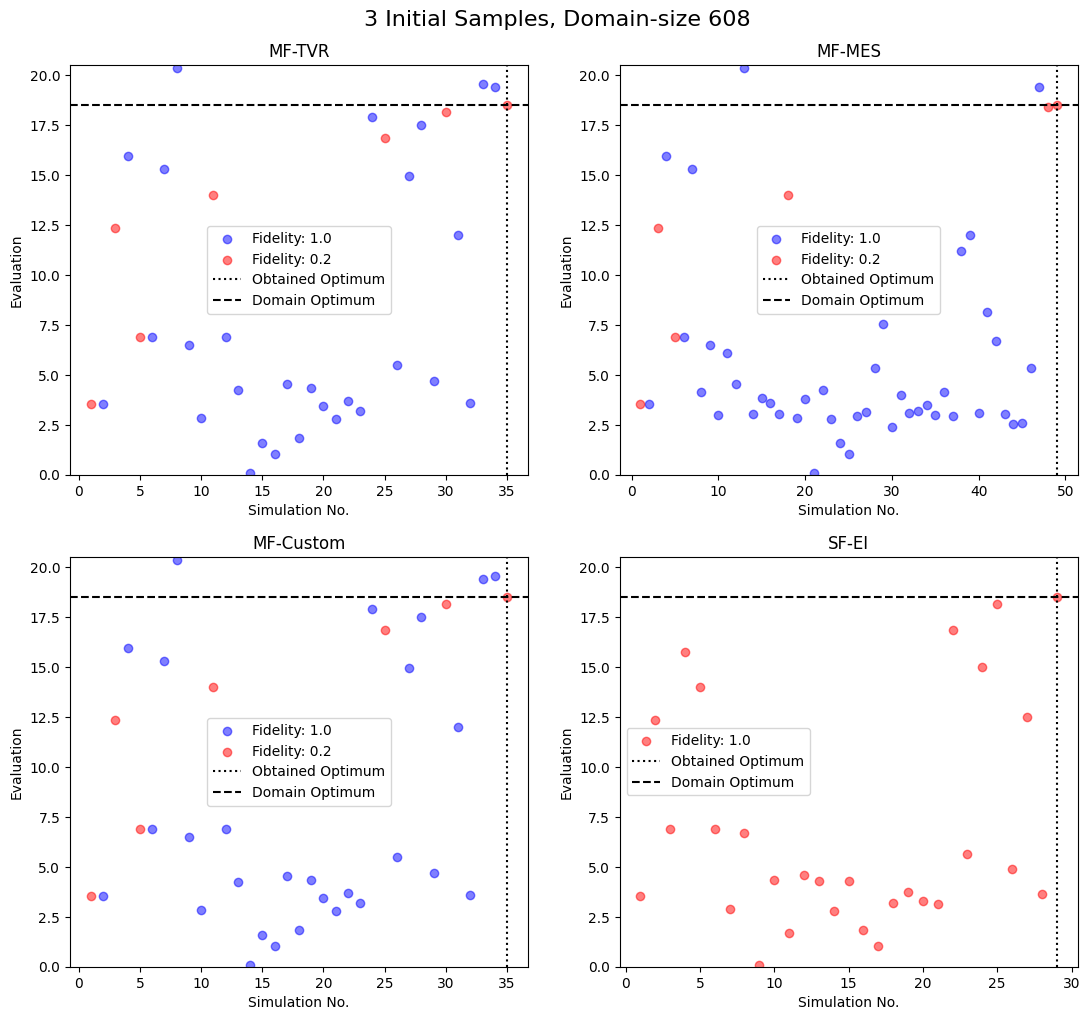

In [151]:
def plot_fidelities_for_dict(dictionary, dictionary_domain, allocated_budget=50, number_init=3):
    figure = plt.figure(figsize=(13,11))
    no_of_rows = math.ceil(len(dictionary.keys())/2)
    for id, key in enumerate(dictionary):
        plt.subplot(no_of_rows, 2, id + 1)
        plot_fidelities(dictionary[key][0], dictionary[key][1], dictionary[key][2], f'{key}', dictionary_domain)
    plt.suptitle(f'{number_init} Initial Samples, Domain-size {int(len(dictionary_domain)/2)}',  size=16)
    plt.subplots_adjust(top=0.93)
    plt.show()

plot_fidelities_for_dict(modelDict, domain)


In [99]:
def plot_corey_simons_like(searc_alg_tuple, domain, title):
    (trainx, obj, cum_cost) = searc_alg_tuple
    max_in_space= np.max(domain[np.where(domain[:, -2] == 1.0)][:, -1])
    index_of_max = np.where(obj == max_in_space)[0]
    length_of_run_until_max = index_of_max.item() if np.size(index_of_max) != 0 else len(trainx) -1
    low_fidelity_points = []
    high_fidelity_points = []
    for i in range(length_of_run_until_max+ 1):
        if trainx[i, -1] == 1:
            if i == 0:
                high_fidelity_points.append(obj[i])
            else:
                if obj[i] > high_fidelity_points[-1]:
                    high_fidelity_points.append(obj[i])
                else:
                    high_fidelity_points.append(high_fidelity_points[-1])
        else:
            if i==0:
                low_fidelity_points.append(0)
            else:
                low_fidelity_points.append(high_fidelity_points[-1])
    high_fidleity_iterations = np.where(trainx[:length_of_run_until_max+1, -1] ==1)[0]
    low_fidleity_iterations = np.where(trainx[:length_of_run_until_max+1, -1] != 1)[0]
    plt.scatter(high_fidleity_iterations + 1, high_fidelity_points, label='High-fidelity', color = 'red')
    plt.scatter(low_fidleity_iterations + 1, low_fidelity_points, label='Low-fidelity',  color = 'blue')       
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.axvline(x=index_of_max + 1, color='black', linestyle='-.', label='Simulation where Optimum reached')

    plt.xlabel('Simulation #, n')
    plt.ylabel('Largest High-fidelity Evaluation')
    plt.xlim(0, index_of_max + 3)
    plt.legend()
    plt.title(title)
    
def plot_corey_simons_for_whole_dictionary(dictionary, domain, number_init=3):
    figure = plt.figure(figsize=(13,11))
    no_of_rows = math.ceil(len(dictionary.keys())/2)
    for id, key in enumerate(dictionary):
        plt.subplot(no_of_rows, 2, id + 1)
        plot_corey_simons_like(dictionary[key], domain, key)
    plt.suptitle(f'{number_init} Initial Samples, Domain-size {int(len(domain)/2)}',  size=16)
    plt.subplots_adjust(top=0.93)
    plt.show()

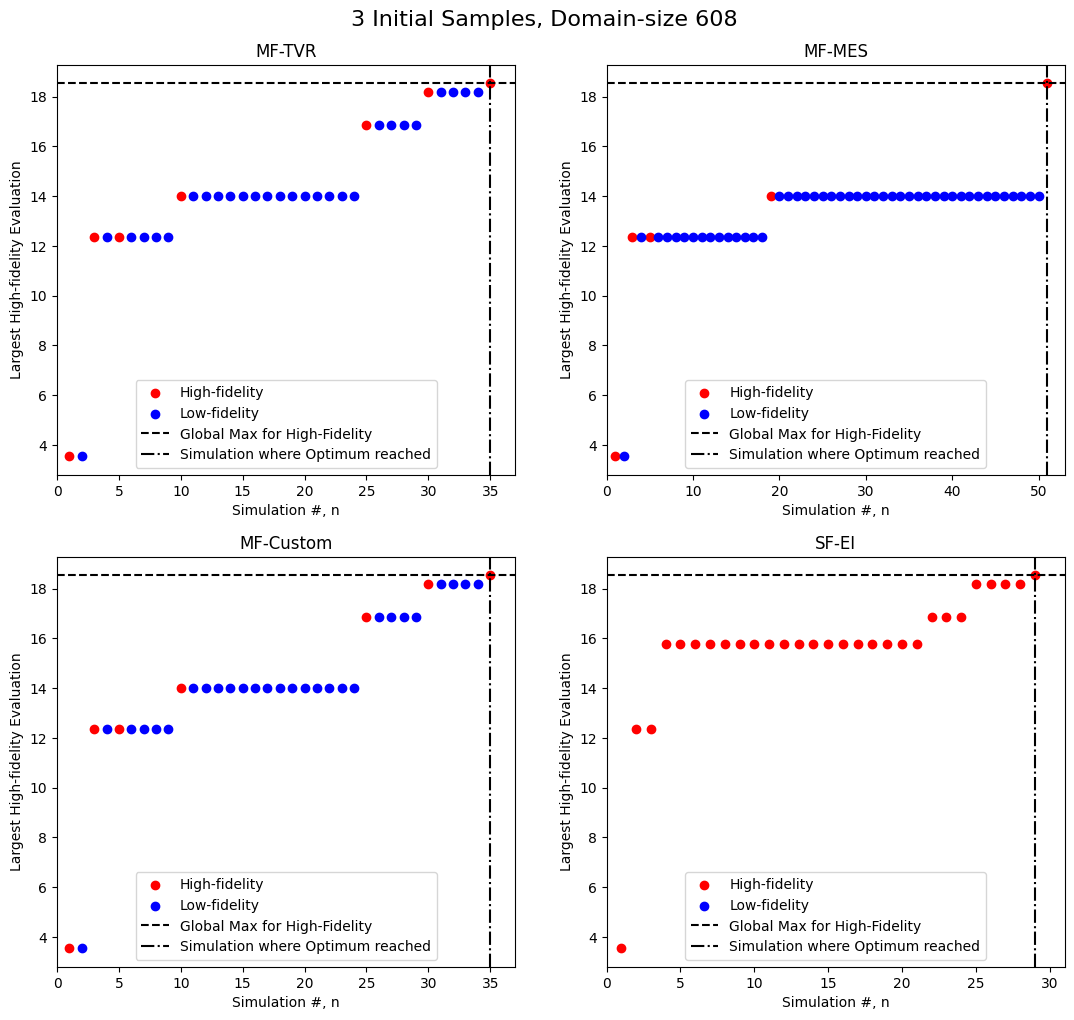

In [81]:
plot_corey_simons_for_whole_dictionary(modelDict, domain,)

In [101]:
#Print High and LF runs
def print_output(dictionary):
    for searchalg in dictionary:
        train, obj, cost = dictionary[searchalg]
        no_calls = len(train)
        hf_calls = len(np.where(train[:,-1]==1)[0])
        lf_calls = len(np.where(train[:,-1]!=1)[0])
        train
        
        print(f'{searchalg} Total Simulations: {no_calls}')
        print(f'{searchalg} HF Simulations: {hf_calls}')
        print(f'{searchalg} LF Simulations: {lf_calls}')
        # print(f'Total Runtime: {}')
        print('\n')

MF-TVR Total Simulations: 35
MF-TVR HF Simulations: 7
MF-TVR LF Simulations: 28


MF-MES Total Simulations: 49
MF-MES HF Simulations: 6
MF-MES LF Simulations: 43


MF-Custom Total Simulations: 35
MF-Custom HF Simulations: 7
MF-Custom LF Simulations: 28


SF-EI Total Simulations: 29
SF-EI HF Simulations: 29
SF-EI LF Simulations: 0




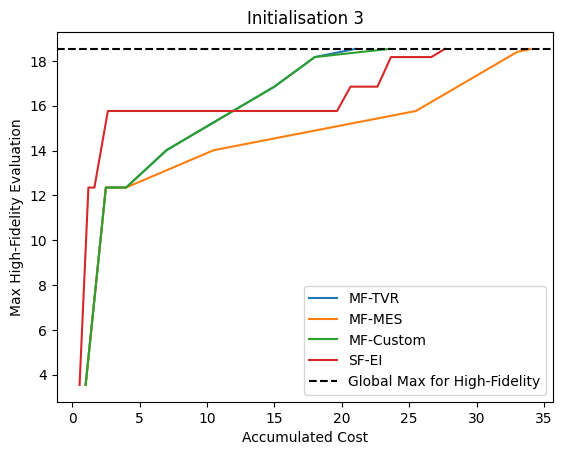

In [24]:
# Here we plot the maximum high-fidelity target reached so far with a given cost. 
def plot_cost(domain, dictionary, title): 
    max_in_space= np.max(domain[np.where(domain[:, -2] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        cumulative_cost_array = np.array(cumulative_cost)
        hf_indices = np.where(train_x_full[:, -1]==1.0)
        high_fidelity_obj = train_obj[np.where(train_x_full[:, -1]==1.0)].detach().numpy()
        accum_target = []
        for i in range(len(high_fidelity_obj)):
            accum_target.append(max(high_fidelity_obj[0:i+1]))

        plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=search_alg)    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Evaluation')
    plt.title(title)
    plt.legend()

plot_cost(domain, modelDict,f'Initialisation {N_INIT}' )

In [26]:
def plot_histogram(domain):
    high_fidelity = domain[np.where(domain[:, -2]==1.0)]
    low_fidelity = domain[np.where(domain[:, -2]!= 1.0)]
    correlation = np.corrcoef(high_fidelity[:, -1], low_fidelity[:, -1])[0,1]

    plt.hist(low_fidelity[:, -1], label=f'Low-fidelity Data (Correlation: {str(correlation)[:4]})', bins=10, alpha=0.5, color='blue')
    plt.hist(high_fidelity[:, -1], label='High-fidelity Data', bins=10, alpha=0.5, color='red')
    plt.title('Distribution of Evaluations')
    plt.xlabel('f(x)')
    plt.ylabel('Frequency')
    plt.legend()

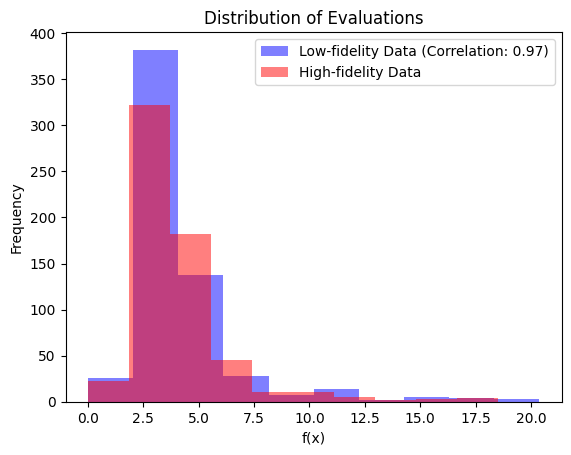

In [27]:
plot_histogram(domain)

In [119]:
init_cof_ids_file = pickle.load(open('../search_results/initializing_cof_ids_normalized.pkl', 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']
fileName = setUpSampleSpace(X, lf_cost=0.5)
array_of_results = []
for i in range(5):
    N_INIT = 3
    initital_ids = initialize_acquired_set(init_cof_ids[i])
    train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, N_INIT, predefined_indices=initital_ids)
    train_x_full_custom, train_obj_custom, cumulative_cost_custom, index_store_custom = run_entire_cycle(
        train_x_full, 
        train_obj, 
        domain, 
        fidelity_history,
        index_store,
        runCustom,
        )
    array_of_results.append([len(train_x_full_custom), np.count_nonzero(train_x_full_custom[:, -1]==1), np.count_nonzero(train_x_full_custom[:, -1]!=1) ])


In [120]:
custom_df = pd.DataFrame(data=array_of_results, columns=['Total Sim.', 'Total HF Sim.', 'Total LF Sim.'])

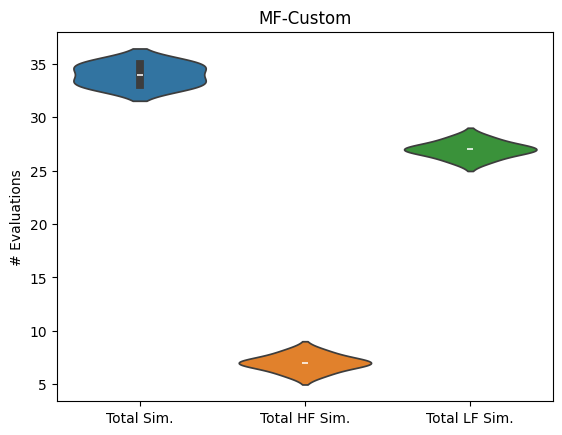

In [121]:
import seaborn as sns

axs = sns.violinplot(data=custom_df)
axs.set_title('MF-Custom')
axs.set_ylabel('# Evaluations')
plt.show()
# custom_df.plot.box()


In [111]:
N_INIT = 3
init_cof_ids_file = pickle.load(open('../search_results/initializing_cof_ids_normalized.pkl', 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']
initital_ids = initialize_acquired_set(init_cof_ids[5])
fileName=setUpSampleSpace(X, lf_cost=0.2)
# fileName = 'CoreySimonsSpace/20240721-110002.csv'
train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, N_INIT, predefined_indices=initital_ids)


In [112]:
train_x_full_tvr_2, train_obj_tvr_2, cumulative_cost_tvr_2, index_store_tvr_2 = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    func=runTVR,
    )

In [113]:
train_x_full_mes_2, train_obj_mes_2, cumulative_cost_mes_2, index_store_mes_2 = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runMes,
    )

In [114]:
train_x_full_custom_2, train_obj_custom_2, cumulative_cost_custom_2, index_store_custom_2 = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runCustom,
    )

In [115]:
# The single fidelity case requires different initial data. For example, the initial sample must be all HF and the domain is all HF.
# The fidelity history is less important here as we know all chosen points will be HF, but we keep them so that we can reuse the same function.
train_x_full_sf, train_obj_sf, domain_sf, index_store_sf, fidelity_history_sf = convertMFDatatoSFData(domain, index_store)
train_x_full_ei_2, train_obj_ei_2, cumulative_cost_ei_2, index_store_ei_2= run_entire_cycle(
    train_x_full_sf, 
    train_obj_sf, 
    domain_sf,
    fidelity_history_sf,
    index_store_sf,
    runEI,
    sf=True,)

In [116]:
modelDict2 = {
    # "MF-TVR_orig": (train_x_full_mes_orig, train_obj_mes_orig, cumulative_cost_mes_orig),
    "MF-TVR": (train_x_full_tvr_2, train_obj_tvr_2, cumulative_cost_tvr_2),
    "MF-MES": (train_x_full_mes_2, train_obj_mes_2, cumulative_cost_mes_2),
    "MF-Custom": (train_x_full_custom_2, train_obj_custom_2, cumulative_cost_custom_2),
    "SF-EI" : (train_x_full_ei_2, train_obj_ei_2, cumulative_cost_ei_2),
             }
dict_filename = save_dictionary(modelDict)
print(dict_filename)
#20240723-191141    

In [147]:
print_output(modelDict2)

MF-TVR Total Simulations: 191
MF-TVR HF Simulations: 95
MF-TVR LF Simulations: 96


MF-MES Total Simulations: 83
MF-MES HF Simulations: 9
MF-MES LF Simulations: 74


MF-Custom Total Simulations: 49
MF-Custom HF Simulations: 16
MF-Custom LF Simulations: 33


SF-EI Total Simulations: 21
SF-EI HF Simulations: 21
SF-EI LF Simulations: 0




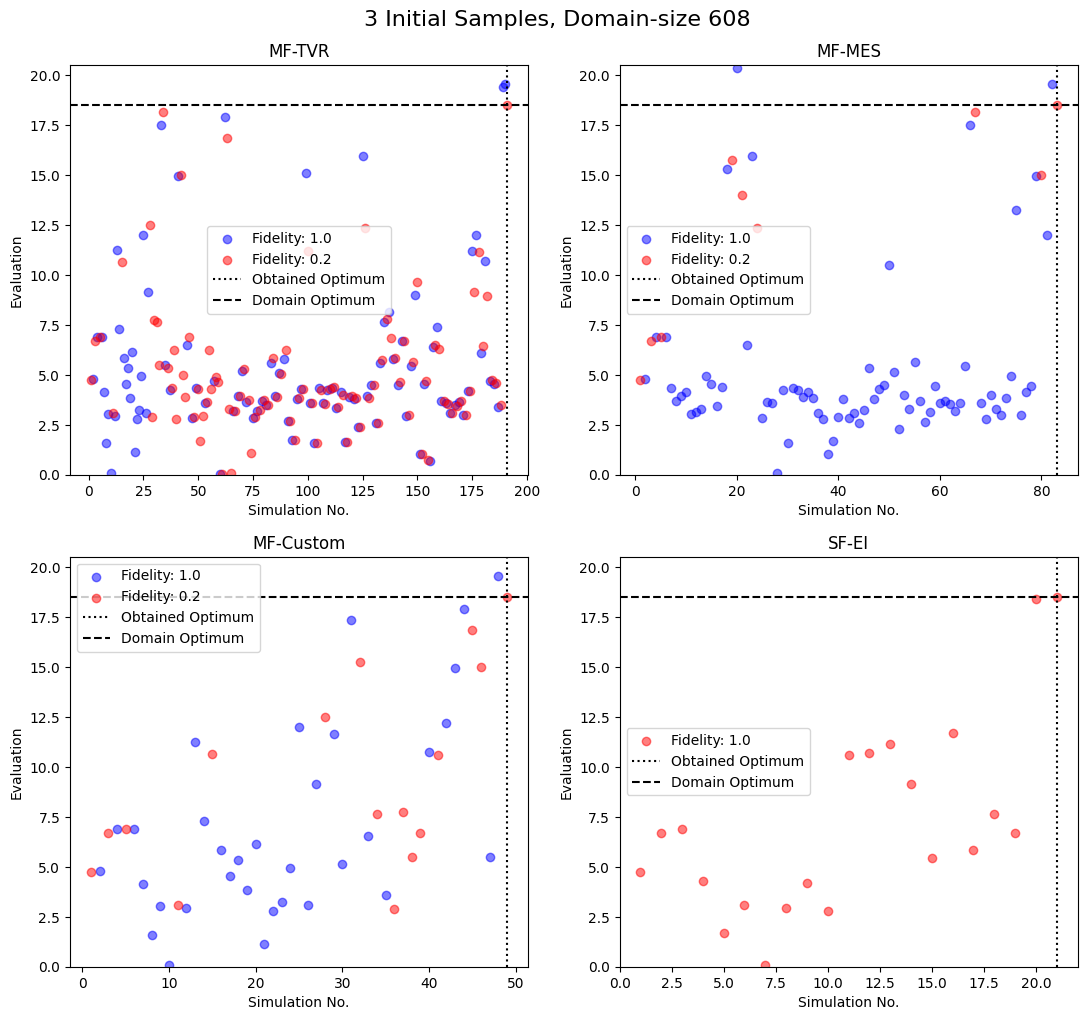

In [152]:
plot_fidelities_for_dict(modelDict2, domain)

# Code to Create Violin-Plot
Need to run for every initialisation stored in the Corey-Simons repo.

In [ ]:
init_cof_ids_file = pickle.load(open('../search_results/initializing_cof_ids_normalized.pkl', 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']
fileName = setUpSampleSpace(X, lf_cost=0.5)
array_of_results = []
directory_name = time.strftime("%Y%m%d-%H%M%S")
for i in range(len(init_cof_ids)):
    N_INIT = 3
    initital_ids = initialize_acquired_set(init_cof_ids[i])
    train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, N_INIT, predefined_indices=initital_ids)
    train_x_full_custom, train_obj_custom, cumulative_cost_custom, index_store_custom = run_entire_cycle(
        train_x_full, 
        train_obj, 
        domain, 
        fidelity_history,
        index_store,
        runCustom,
        )
    train_x_full_tvr, train_obj_tvr, cumulative_cost_tvr, index_store_tvr = run_entire_cycle(
        train_x_full, 
        train_obj, 
        domain, 
        fidelity_history,
        index_store,
        func=runTVR,
        )
    train_x_full_mes, train_obj_mes, cumulative_cost_mes, index_store_mes = run_entire_cycle(
        train_x_full, 
        train_obj, 
        domain, 
        fidelity_history,
        index_store,
        runMes,
        )
    train_x_full_sf, train_obj_sf, domain_sf, index_store_sf, fidelity_history_sf = convertMFDatatoSFData(domain, index_store)
    train_x_full_ei, train_obj_ei, cumulative_cost_ei, index_store_ei= run_entire_cycle(
        train_x_full_sf, 
        train_obj_sf, 
        domain_sf,
        fidelity_history_sf,
        index_store_sf,
        runEI,
        sf=True,)
    modelDict = {
        # "MF-TVR_orig": (train_x_full_mes_orig, train_obj_mes_orig, cumulative_cost_mes_orig),
        "MF-TVR": (train_x_full_tvr, train_obj_tvr, cumulative_cost_tvr),
        "MF-MES": (train_x_full_mes, train_obj_mes, cumulative_cost_mes),
        "MF-Custom": (train_x_full_custom, train_obj_custom, cumulative_cost_custom),
        "SF-EI" : (train_x_full_ei, train_obj_ei, cumulative_cost_ei),
                 }
    dict_filename = save_dictionary(modelDict, root=directory_name)
#     array_of_results.append([len(train_x_full_custom), np.count_nonzero(train_x_full_custom[:, -1]==1), np.count_nonzero(train_x_full_custom[:, -1]!=1) ])


In [ ]:
stored_directory ='20240724-110054' 
directories = os.listdir(stored_directory)
custom_array_of_results = []
mes_array_of_results = []
tvr_array_of_results = []
sf_ei_array_of_results = []
keys = ["MF-TVR", "MF-MES", "MF-Custom", "SF-EI" ]
for file in directories:
    modelDict = load_dictionary(f'{stored_directory}/{file}')
    for key in keys:
        train, obj, cumulative = modelDict[key]
        if key == 'MF-MES':
            mes_array_of_results.append([len(train), np.count_nonzero(train[:, -1]==1), np.count_nonzero(train[:, -1]!=1) ])
        elif key == 'MF-TVR':
            tvr_array_of_results.append([len(train), np.count_nonzero(train[:, -1]==1), np.count_nonzero(train[:, -1]!=1) ])
        elif key == 'MF-Custom':
            custom_array_of_results.append([len(train), np.count_nonzero(train[:, -1]==1), np.count_nonzero(train[:, -1]!=1) ])
        elif key == 'SF-EI':
            sf_ei_array_of_results.append([len(train), np.count_nonzero(train[:, -1]==1), np.count_nonzero(train[:, -1]!=1) ])
        else:
            raise Exception('Invalid Dictionary key')

In [ ]:
custom_df = pd.DataFrame(data=custom_array_of_results, columns=['Total Sim.', 'Total HF Sim.', 'Total LF Sim.'])
mes_df = pd.DataFrame(data=mes_array_of_results, columns=['Total Sim.', 'Total HF Sim.', 'Total LF Sim.'])
tvr_df = pd.DataFrame(data=tvr_array_of_results, columns=['Total Sim.', 'Total HF Sim.', 'Total LF Sim.'])
sf_df = pd.DataFrame(data=sf_ei_array_of_results, columns=['Total Sim.', 'Total HF Sim.', 'Total LF Sim.'])
array = [mes_df, tvr_df, custom_df, sf_df ]


In [ ]:
import seaborn as sns
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(13, 20))

for id, df in enumerate(array):
    sns.violinplot(data=df, ax=axs[id])
    axs[id].set_title(keys[id])
    axs[id].set_ylabel('# Evaluations')    
plt.subplots_adjust(top=0.90)
plt.show()
# custom_df.plot.box()


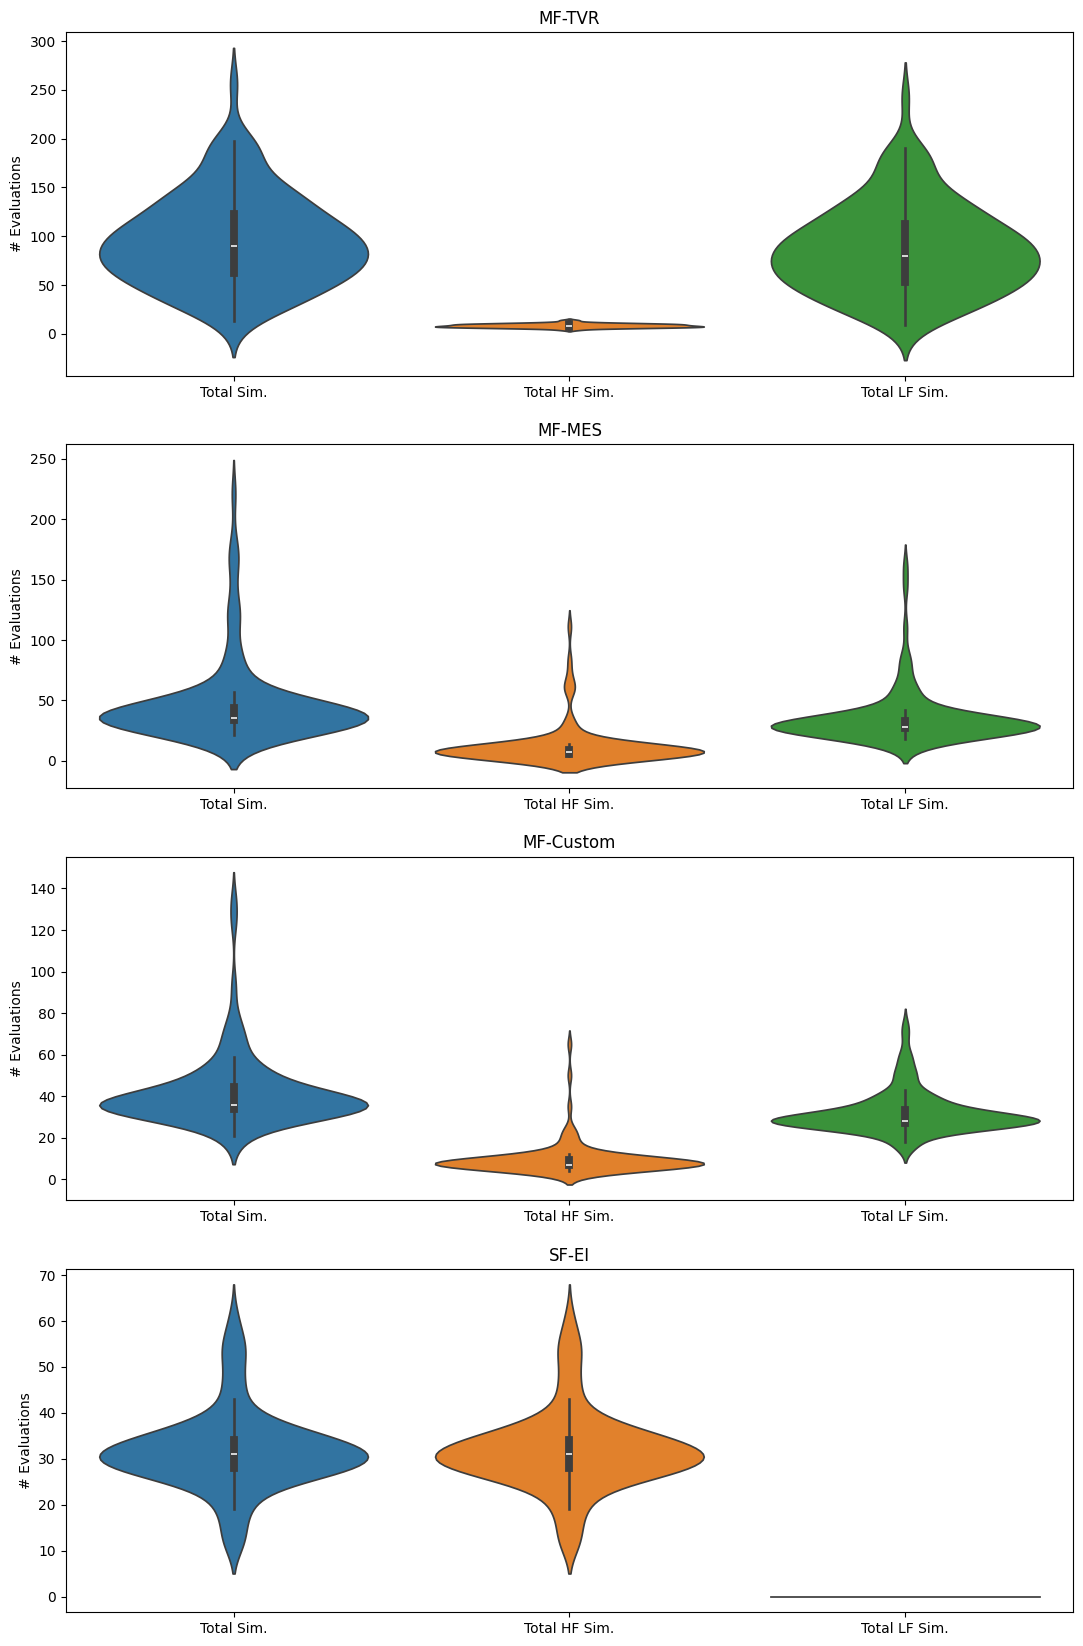